## **Начало работы**
### Импорт библиотек

In [20]:
import pymysql
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import matplotlib.patches as mpatches
import seaborn as sns

import re
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

### Подключение к БД

In [2]:
dbname = 'cowrie'
user = 'cowrie'
port = 3306

NL_password = os.environ.get('NL_PASSWORD')
NL_host = os.environ.get('NL_HOST')

RU_password = os.environ.get('RU_PASSWORD')
RU_host = os.environ.get('RU_HOST')

KZ_password = os.environ.get('KZ_PASSWORD')
KZ_host = os.environ.get('KZ_HOST')

NL_conn = pymysql.connect(database=dbname, user=user, password=NL_password, host=NL_host, port=port)
RU_conn = pymysql.connect(database=dbname, user=user, password=RU_password, host=RU_host, port=port)
KZ_conn = pymysql.connect(database=dbname, user=user, password=KZ_password, host=KZ_host, port=port)

## Загрузка данных

In [3]:
def load_df(connection):
    tables = [
        'auth', 'clients', 'input', 'sensors', 'sessions',
        'ttylog', 'downloads', 'keyfingerprints', 'params',
        'ipforwards', 'geo'
    ]
    df = {}
    for table in tables:
        df[table] = pd.read_sql(f'SELECT * FROM {table}', connection)
    return df

In [4]:
NL_df = load_df(NL_conn)
RU_df = load_df(RU_conn)
KZ_df = load_df(KZ_conn)

/tmp/ipykernel_410231/3692076813.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df[table] = pd.read_sql(f'SELECT * FROM {table}', connection)


## **EDA**

## Обработка пропущенных значений
#### Здесь внимание уделяется таблицам input, sessios

In [5]:
def check_missing_values(database, db_name):
    print(f"Пропущенные значения в БД {db_name}:")
    for table_name, table in database.items():
        missing_values = table.isnull().sum()
        print(f"\nTable: {table_name}")
        print(missing_values)
        
RU_df['input'] = RU_df['input'].drop(columns=['realm'])
KZ_df['input'] = KZ_df['input'].drop(columns=['realm'])
NL_df['input'] = NL_df['input'].drop(columns=['realm'])

RU_df['sessions'] = RU_df['sessions'].drop(columns=['termsize'])
KZ_df['sessions'] = KZ_df['sessions'].drop(columns=['termsize'])
NL_df['sessions'] = NL_df['sessions'].drop(columns=['termsize'])

RU_df['sessions'] = RU_df['sessions'].dropna(subset=['client'])
KZ_df['sessions'] = KZ_df['sessions'].dropna(subset=['client'])
NL_df['sessions'] = NL_df['sessions'].dropna(subset=['client'])

check_missing_values(RU_df, 'RU_df')
check_missing_values(KZ_df, 'KZ_df')
check_missing_values(NL_df, 'NL_df')

Пропущенные значения в БД RU_df:

Table: auth
id           0
session      0
success      0
username     0
password     0
timestamp    0
dtype: int64

Table: clients
id         0
version    0
dtype: int64

Table: input
id           0
session      0
timestamp    0
success      0
input        0
dtype: int64

Table: sensors
id    0
ip    0
dtype: int64

Table: sessions
id             0
starttime      0
endtime      383
sensor         0
ip             0
client         0
dtype: int64

Table: ttylog
id         0
session    0
ttylog     0
size       0
dtype: int64

Table: downloads
id           0
session      0
timestamp    0
url          0
outfile      0
shasum       0
dtype: int64

Table: keyfingerprints
id             0
session        0
username       0
fingerprint    0
dtype: int64

Table: params
id         0
session    0
arch       0
dtype: int64

Table: ipforwards
id           0
session      0
timestamp    0
dst_ip       0
dst_port     0
dtype: int64

Table: geo
ip              0
country

## Удаление дубликатов
#### Не возникло необходимости на данном этапе*

In [6]:
def duplicates(df):
    dupl = False
    for table, df in df.items():
        duplicates = df.duplicated()
        if duplicates.any():
            dupl = True
            print(f"В таблице '{table}' есть дубликаты:")
            print(df[duplicates])
    if not dupl:
        print('Дубликатов нет')
print(f'{duplicates(RU_df)}, {duplicates(KZ_df)}, {duplicates(NL_df)}')

Дубликатов нет
Дубликатов нет
Дубликатов нет
None, None, None


## Статистика

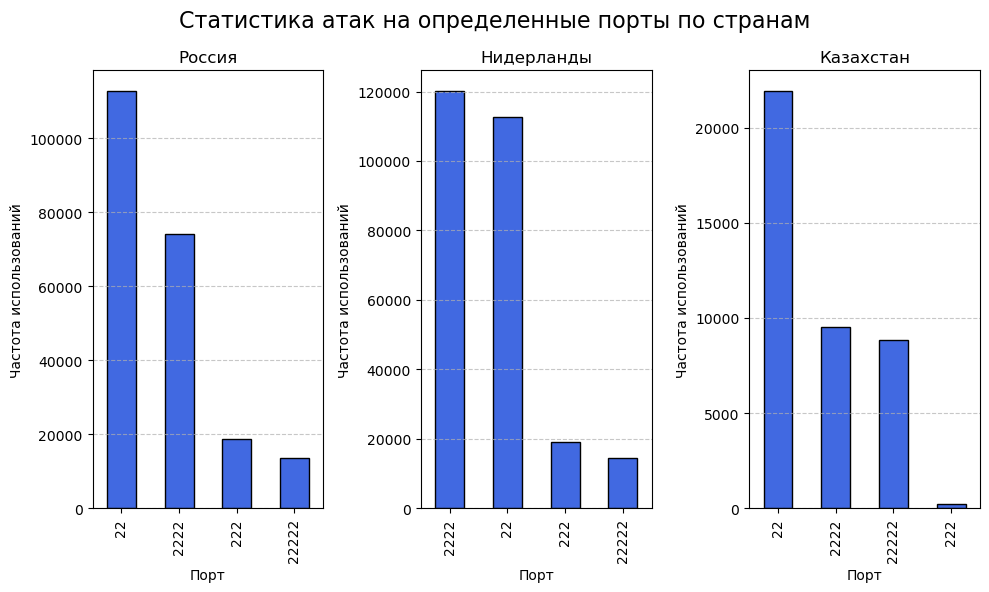

In [7]:
sensor_mapping = {1: '2222', 2: '22', 3: '222', 4: '22222'}
sensor_mapping_RU = {1: '22', 2: '2222', 3: '222', 4: '22222'}

RU_df['sensor_description'] = RU_df['sessions']['sensor'].replace(sensor_mapping_RU)
NL_df['sensor_description'] = NL_df['sessions']['sensor'].replace(sensor_mapping)
KZ_df['sensor_description'] = KZ_df['sessions']['sensor'].replace(sensor_mapping)

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
RU_df['sensor_description'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black')
plt.xlabel('Порт')
plt.ylabel('Частота использований')
plt.title('Россия')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
NL_df['sensor_description'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black')
plt.xlabel('Порт')
plt.ylabel('Частота использований')
plt.title('Нидерланды')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
KZ_df['sensor_description'].value_counts().plot(kind='bar', color='royalblue', edgecolor='black')
plt.xlabel('Порт')
plt.ylabel('Частота использований')
plt.title('Казахстан')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Статистика атак на определенные порты по странам', fontsize=16)
plt.tight_layout()
plt.savefig('ports.png')
plt.show()

In [8]:
combined_df = pd.concat([RU_df['auth'], NL_df['auth'], KZ_df['auth']], ignore_index=True)
combined_df['username_password'] = combined_df['username'] + ' | ' + combined_df['password']

top_combinations = combined_df['username_password'].value_counts().head(5)

print('Самые часто встречающиеся комбинации логин + пароль:')
for combination, count in top_combinations.items():
    percent = count / len(combined_df) * 100
    print(f'{combination}: {count} ({percent:.1f}%)')

Самые часто встречающиеся комбинации логин + пароль:
345gs5662d34 | 345gs5662d34: 24126 (5.1%)
root | 3245gs5662d34: 11601 (2.5%)
admin | admin: 1333 (0.3%)
root | 0: 1201 (0.3%)
0 | 0: 1015 (0.2%)


## **Классификация**

## Предобработка

In [9]:
KZ_df_input = KZ_df['input']
RU_df_input = RU_df['input']
NL_df_input = NL_df['input']

In [10]:
def process_input_data(df):
    commands = []
    for row in df['input']:
        split_commands = row.split('&&')
        split_commands = [cmd.strip() for cmd in split_commands]
        commands.extend(split_commands)
    return commands

def process(df_input):
    commands = process_input_data(df_input)
    commands_df = pd.DataFrame(commands, columns=['command'])
    commands_df = commands_df.drop_duplicates()
    return commands_df

In [11]:
KZ_commands_df = process(KZ_df_input)
RU_commands_df = process(RU_df_input)
NL_commands_df = process(NL_df_input)

## Разметка данных

In [12]:
command_categories = {
    'uname -s -m': 'Системная информация',
    'cd ~': 'Файловая система',
    'chattr -ia .ssh': 'Файловая система',
    'lockr -ia .ssh': 'Безопасность',
    'echo "ssh-key" > .ssh/authorized_keys': 'Конфигурация'
}

additional_keywords = {
    'Системная информация': ['rm -rf', 'miner', 'cpu', 'gpu', 'useradd','nvidia-smi', 'uname', 'top', '[Mm]iner', 'free -m | grep Mem'],
    'Файловая система': ['cd', 'mkdir', 'chattr', 'cat', 'head -c 2356344 > /tmp/L6Q8AwPTnV', 'head -c 2356344 > /tmp/KWKTrhw6WE', 'ls'],
    'Безопасность': ['lockr', 'chmod', 'wget', 'curl', 'apt',  'openssl passwd', 'rm -rf .ssh', 'mkdir .ssh', 'usermod', 'whoami', 'crontab -l'],
    'Конфигурация': ['echo', 'ifconfig']
}

In [13]:
def categorize_command(command):
    if command in command_categories:
        return command_categories[command]
    for category, keywords in additional_keywords.items():
        if any(keyword in command for keyword in keywords):
            return category
    return 'Другое'

KZ_commands_df['category'] = KZ_commands_df['command'].apply(categorize_command)
RU_commands_df['category'] = RU_commands_df['command'].apply(categorize_command)
NL_commands_df['category'] = NL_commands_df['command'].apply(categorize_command)

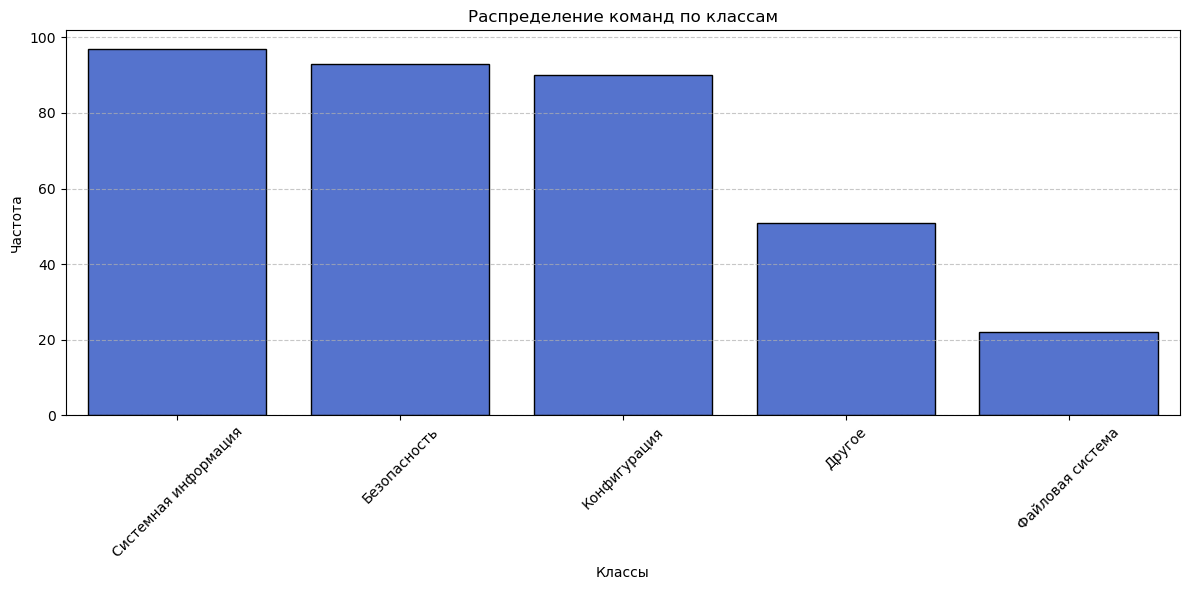

In [14]:
plt.figure(figsize = (12, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.countplot(x = 'category', data = KZ_commands_df, order = KZ_commands_df['category'].value_counts().index, color = 'royalblue', edgecolor='black')
plt.title('Распределение команд по классам')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Category.png')
plt.show()

## **Градиентный бустинг**
### Обучение на данных KZ

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(KZ_commands_df['command'])
y = KZ_commands_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8773584905660378

Classification Report:
                      precision    recall  f1-score   support

        Безопасность       0.96      0.89      0.92        27
              Другое       0.60      0.92      0.73        13
        Конфигурация       0.93      1.00      0.97        28
Системная информация       0.92      0.92      0.92        26
    Файловая система       1.00      0.42      0.59        12

            accuracy                           0.88       106
           macro avg       0.88      0.83      0.83       106
        weighted avg       0.90      0.88      0.87       106



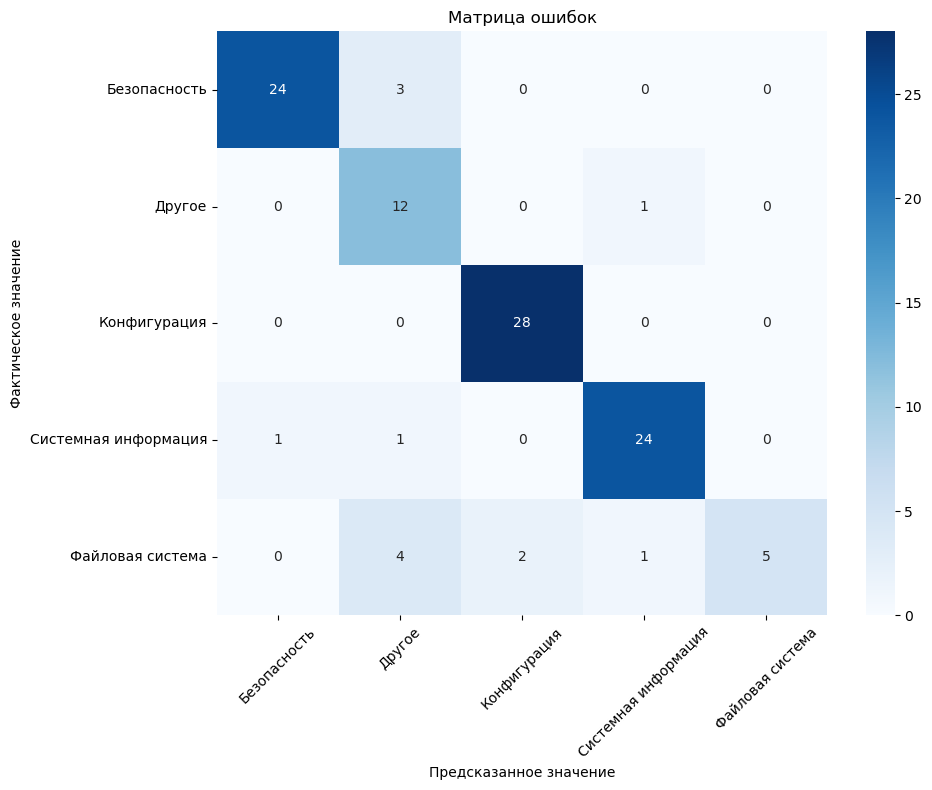

In [16]:
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_df = pd.DataFrame(cm, index = clf.classes_, columns = clf.classes_)

plt.figure(figsize = (10, 8))
sns.heatmap(cm_df, annot = True, fmt = 'd', cmap = 'Blues')
plt.ylabel('Фактическое значение')
plt.xlabel('Предсказанное значение')
plt.title('Матрица ошибок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('matrix_KZ.png')
plt.show()

### Балансировка классов при помощи SMOTE

In [17]:
smote = SMOTE(random_state=42, k_neighbors=7)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

clf = GradientBoostingClassifier()
clf.fit(X_train_balanced, y_train_balanced)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nОтчет качества модели:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8867924528301887

Отчет качества модели:
                      precision    recall  f1-score   support

        Безопасность       0.96      0.89      0.92        27
              Другое       0.60      0.92      0.73        13
        Конфигурация       0.93      0.96      0.95        28
Системная информация       0.96      0.92      0.94        26
    Файловая система       1.00      0.58      0.74        12

            accuracy                           0.89       106
           macro avg       0.89      0.86      0.86       106
        weighted avg       0.91      0.89      0.89       106



### Настройка гиперпараметров

In [18]:
clf = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'max_depth': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка точности:", grid_search.best_score_)

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

print("\nAccuracy на тестовой выборке:", accuracy_score(y_test, y_pred))
print("\nОтчет качества модели:")
print(classification_report(y_test, y_pred))

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая оценка точности: 0.9028571428571428

Accuracy на тестовой выборке: 0.8584905660377359

Отчет качества модели:
                      precision    recall  f1-score   support

        Безопасность       0.96      0.89      0.92        27
              Другое       0.53      0.77      0.62        13
        Конфигурация       0.93      1.00      0.97        28
Системная информация       0.96      0.92      0.94        26
    Файловая система       0.71      0.42      0.53        12

            accuracy                           0.86       106
           macro avg       0.82      0.80      0.80       106
        weighted avg       0.87      0.86      0.86       106



### Применение модели к новым данным (RU, NL)

In [19]:
X_ru = vectorizer.transform(RU_commands_df['command'])
y_ru = RU_commands_df['category'] 

X_nl = vectorizer.transform(NL_commands_df['command']) 
y_nl = NL_commands_df['category']  

y_pred_ru = best_clf.predict(X_ru)

print("Accuracy на данных RU:", accuracy_score(y_ru, y_pred_ru))
print("\nОтчет качества модели на данных RU:")
print(classification_report(y_ru, y_pred_ru))

y_pred_nl = best_clf.predict(X_nl)

print("\nAccuracy на данных NL:", accuracy_score(y_nl, y_pred_nl))
print("\nОтчет качества модели на данных NL:")
print(classification_report(y_nl, y_pred_nl))

Accuracy на данных RU: 0.7039417309340189

Отчет качества модели на данных RU:
                      precision    recall  f1-score   support

        Безопасность       0.57      0.91      0.70       766
              Другое       0.88      0.99      0.93       362
        Конфигурация       0.82      1.00      0.90       465
Системная информация       0.90      0.06      0.12       579
    Файловая система       0.98      0.51      0.67       162

            accuracy                           0.70      2334
           macro avg       0.83      0.70      0.66      2334
        weighted avg       0.78      0.70      0.63      2334


Accuracy на данных NL: 0.6929744525547445

Отчет качества модели на данных NL:
                      precision    recall  f1-score   support

        Безопасность       0.56      0.94      0.70       733
              Другое       0.82      0.99      0.90       282
        Конфигурация       0.88      1.00      0.93       441
Системная информация       0.98

## **Логистическая регрессия**
### С применением L2 регуляризатора

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(KZ_commands_df['command'])
y = KZ_commands_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nОтчет по результатам классификации с помощью логистической регрессии:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8018867924528302

Отчет по результатам классификации с помощью логистической регрессии:
                      precision    recall  f1-score   support

        Безопасность       0.77      0.89      0.83        27
              Другое       0.56      0.77      0.65        13
        Конфигурация       0.96      0.93      0.95        28
Системная информация       0.83      0.96      0.89        26
    Файловая система       0.00      0.00      0.00        12

            accuracy                           0.80       106
           macro avg       0.63      0.71      0.66       106
        weighted avg       0.72      0.80      0.76       106



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Применение модели к RU и NL данным

In [26]:
y_pred_ru = clf.predict(X_ru)
y_pred_nl = clf.predict(X_nl)

print("Accuracy на данных RU:", accuracy_score(y_ru, y_pred_ru))
print("\nОтчет качества модели на данных RU:")
print(classification_report(y_ru, y_pred_ru))

print("\nAccuracy на данных NL:", accuracy_score(y_nl, y_pred_nl))
print("\nОтчет качества модели на данных NL:")
print(classification_report(y_nl, y_pred_nl))

Accuracy на данных RU: 0.8556126820908312

Отчет качества модели на данных RU:
                      precision    recall  f1-score   support

        Безопасность       0.77      0.99      0.87       766
              Другое       0.88      0.86      0.87       362
        Конфигурация       0.86      0.61      0.71       465
Системная информация       0.96      0.99      0.97       579
    Файловая система       1.00      0.44      0.61       162

            accuracy                           0.86      2334
           macro avg       0.89      0.78      0.81      2334
        weighted avg       0.87      0.86      0.85      2334


Accuracy на данных NL: 0.864507299270073

Отчет качества модели на данных NL:
                      precision    recall  f1-score   support

        Безопасность       0.79      0.99      0.88       733
              Другое       0.82      0.87      0.85       282
        Конфигурация       0.90      0.62      0.74       441
Системная информация       0.98 